## Find theoretical meridional modes, dispersion relation, and wavespeeds

In [5]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from numpy import pi
import scipy.io as sio
import matplotlib.colors as Colors
%matplotlib inline 
import warnings
import numpy.polynomial as poly
from tools.transform_tools import *
from tools.data_processing_tools import *
from tools.theoretical_tools import *
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['text.usetex'] = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# ---------------- Data for panels a and b -----------------

# Load in TAO dynamic height data 
t_TAO, lat_TAO, lon_TAO, lon_TAO_midpoints, D_TAO, ds_TAO = load_TAO(NEMO_year=True)
D_TAO_eq = D_TAO[:,3,:]

# Load in all NEMO data, sampled to TAO locations, at the equator
t, lat_NEMO, lon_NEMO, D_NEMO_eq, ds_NEMO, tau_x, tau_y = load_NEMO(daily_mean=True,lats=np.array([0]),lons=lon_TAO, winds=True)

# Remove datapoints in dynamic height and wind stress where TAO data is missing
D_NEMO_eq = np.where(np.isnan(D_TAO_eq),np.nan,D_NEMO_eq)
tau_x = np.where(np.isnan(D_TAO_eq),np.nan,tau_x)
tau_y = np.where(np.isnan(D_TAO_eq),np.nan,tau_y)

# Two stage high pass filter, then zonal average of wind stress and dynamic height
smooth_N = 21 # Rolling mean window length for first high pass
NSR = 35 # Noise to signal ratio
cutoff = 20 # Cutoff period in days for low pass filter

# First remove a rolling mean of length smooth_N
D_NEMO_hf1 = D_NEMO_eq - smooth(D_NEMO_eq,smooth_N)
D_TAO_hf1 = D_TAO_eq - smooth(D_TAO_eq,smooth_N)
tau_x_hf1 = tau_x - smooth(tau_x,smooth_N)
tau_y_hf1 = tau_y - smooth(tau_y,smooth_N)

# Then fit temporal modes to this and cutoff at 20 days to give a low pass filter
D_NEMO_lf = least_squares_spectrum_t_multi(D_NEMO_hf1, t, NSR=NSR, reconstruct_min_period = cutoff)[2]
D_NEMO_hf = D_NEMO_hf1 - D_NEMO_lf
D_NEMO_hf -= np.nanmean(D_NEMO_hf,axis=0)

tau_x_lf = least_squares_spectrum_t_multi(tau_x_hf1, t, NSR=NSR, reconstruct_min_period = cutoff)[2]
tau_x_hf = tau_x_hf1 - tau_x_lf
tau_x_hf -= np.nanmean(tau_x_hf,axis=0)

tau_y_lf = least_squares_spectrum_t_multi(tau_y_hf1, t, NSR=NSR, reconstruct_min_period = cutoff)[2]
tau_y_hf = tau_y_hf1 - tau_y_lf
tau_y_hf -= np.nanmean(tau_y_hf,axis=0)

D_TAO_lf = least_squares_spectrum_t_multi(D_TAO_hf1, t, NSR=NSR, reconstruct_min_period = cutoff)[2]
D_TAO_hf = D_TAO_hf1 - D_TAO_lf
D_TAO_hf -= np.nanmean(D_TAO_hf,axis=0)

# Zonally average
D_NEMO_hf_za = np.nanmean(D_NEMO_hf,axis=1)
D_TAO_hf_za = np.nanmean(D_TAO_hf,axis=1)
tau_y_hf_za = np.nanmean(tau_y_hf,axis=1)
tau_x_hf_za = np.nanmean(tau_x_hf,axis=1)


In [7]:
# ---------------- Data for panels c and d -----------------

# Find baroclinic wave speeds globally
contents=sio.loadmat('../../data/baroclinic_wave_speeds/baroclinic_wave_speeds.mat')
c1global = np.squeeze(contents['c1'])
c2global = np.squeeze(contents['c2'])
clat = np.squeeze(contents['lat'])
clon = np.squeeze(contents['lon'])

In [8]:
# ---------------- Data for panel f -----------------
# Wavenumber vector in degrees^{-1}
k_wavenumbers = np.linspace(-0.1,0.1,101)

freqbc1, freqbc2, c1, c2, lon_freqs, k_wavenumbers = find_predicted_freqs(9,k_wavenumbers=k_wavenumbers,
                                                       lon_lims=[lon_TAO_midpoints[0],lon_TAO_midpoints[-1]],
                                                       lat_lims=[-12,12],average_lon = True)


In [5]:
# ---------------- Data for panel e -----------------
# Find the first 6 meridional modes at baroclinic wave speed 2.8 m/s (approx baroclinic mode 1)
y = np.linspace(-12,12,100)
V_modes , P_modes = calc_meridional_modes(y,N=6,cm=c1)

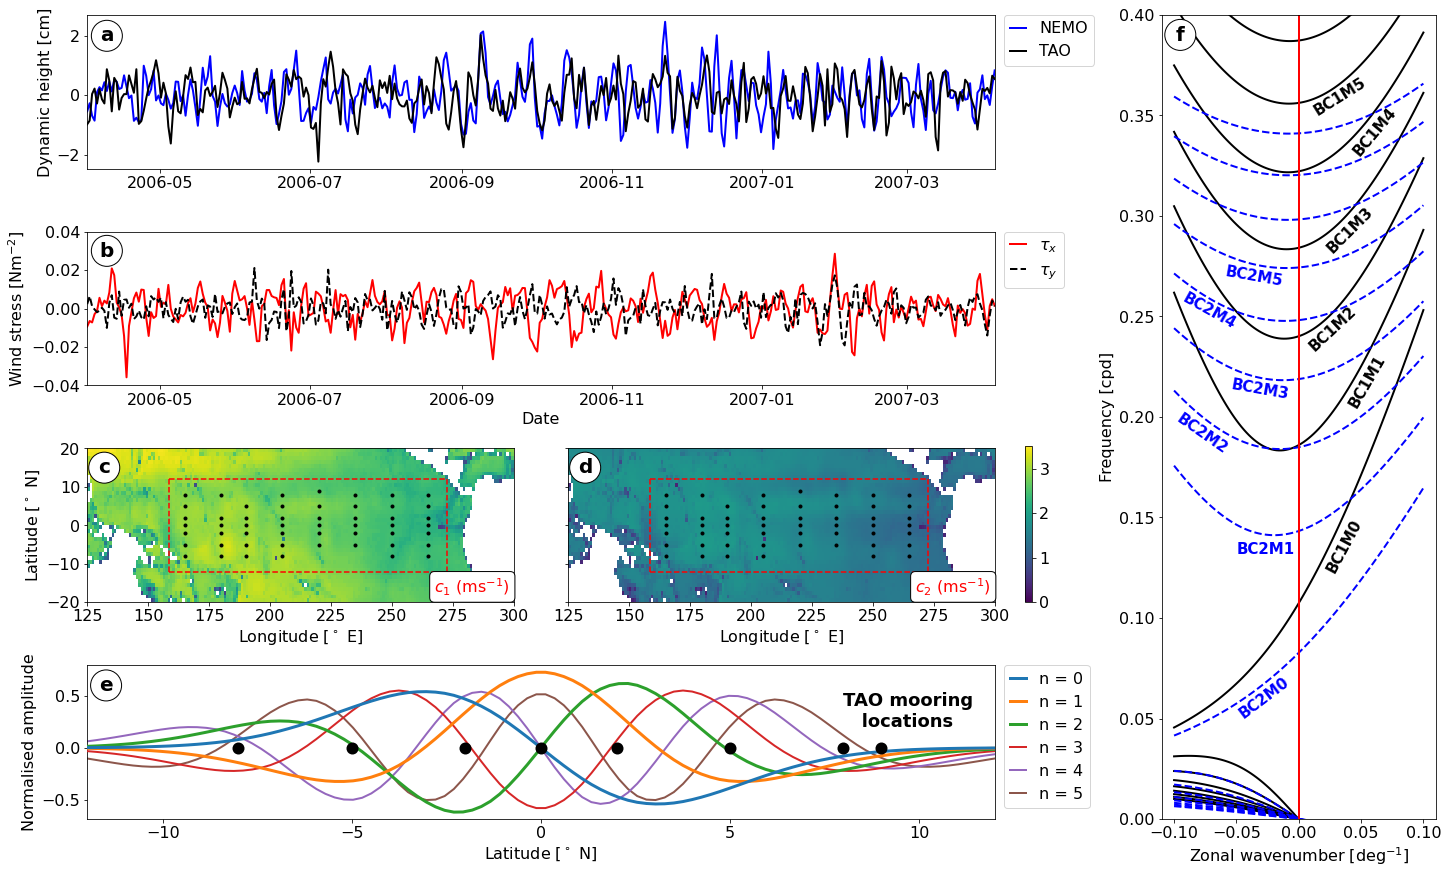

In [6]:
# ---------- Initialise figure and axes ------------

fig = plt.figure(figsize = (20,12), constrained_layout=True)

ax1 = plt.subplot2grid((4, 8), (0, 0), colspan=6)
ax2 = plt.subplot2grid((4, 8), (1, 0), colspan=6)
ax3 = plt.subplot2grid((4, 8), (2, 0), colspan=3)
ax4 = plt.subplot2grid((4, 8), (2, 3), colspan=3)
ax5 = plt.subplot2grid((4, 8), (3, 0), colspan=6)
ax6 = plt.subplot2grid((4, 8), (0, 6),rowspan=4,colspan=2)


# ---------- Panel a, axis 1 ------------

ax1.plot(ds_TAO.time,D_NEMO_hf_za,color='blue',linewidth=2,label='NEMO')
ax1.plot(ds_TAO.time,D_TAO_hf_za,color='black',linewidth=2,label='TAO')

ax1.set_ylabel('Dynamic height [cm]')
ax1.set_xlim([ds_TAO.time[0],ds_TAO.time[-1]])
ax1.legend(ncol=1,bbox_to_anchor=(1.01,1), borderaxespad=0,handlelength=1)
ax1.text(ds_TAO.time[8],2,'a',fontsize=20,color='black',weight='bold',ha="center", va="center", bbox=dict(boxstyle="circle", ec='black',fc='white',))

# ---------- Panel b, axis 2 ------------

ax2.plot(ds_TAO.time,tau_x_hf_za,color='red',linewidth=2,label=r'$\tau_x$')
ax2.plot(ds_TAO.time,tau_y_hf_za,'--',color='black',linewidth=2,label=r'$\tau_y$')
ax2.legend(loc=4)
ax2.set_ylabel('Wind stress [Nm$^{-2}$]')
ax2.set_ylim([-0.04,0.04])
ax2.set_xlim([ds_TAO.time[0],ds_TAO.time[-1]])
ax2.set_xlabel('Date')
ax2.legend(ncol=1,bbox_to_anchor=(1.01,1), borderaxespad=0,handlelength=1)
ax2.text(ds_TAO.time[8],0.03,'b',fontsize=20,color='black',weight='bold',ha="center", va="center", bbox=dict(boxstyle="circle", ec='black',fc='white',))

# ---------- Panels c and d, axes 3 and 4 ------------

# Plot baroclinic wavespeed
p =ax3.pcolormesh(clon,clat,c1global,vmin = 0, vmax = 3.5)
ax4.pcolormesh(clon,clat,c2global,vmin = 0, vmax = 3.5)


# Plot TAO mooring locations
for ilat,lat in enumerate(lat_TAO):
    for ilon, lon in enumerate(lon_TAO):
        if np.sum(~np.isnan(D_TAO[:,ilat,ilon]),axis=0) > 0:
            ax3.plot(lon,lat,'ok',markersize=3)
            ax4.plot(lon,lat,'ok',markersize=3)
            
# Plot NEMO subdomain
ax3.plot(np.linspace(lon_TAO_midpoints[0],lon_TAO_midpoints[-1],10),np.linspace(-12,-12,10),'--',color='red')
ax3.plot(np.linspace(lon_TAO_midpoints[0],lon_TAO_midpoints[-1],10),np.linspace(12,12,10),'--',color='red')
ax3.plot(np.linspace(lon_TAO_midpoints[0],lon_TAO_midpoints[0],10),np.linspace(-12,12,10),'--',color='red')
ax3.plot(np.linspace(lon_TAO_midpoints[-1],lon_TAO_midpoints[-1],10),np.linspace(-12,12,10),'--',color='red')

ax4.plot(np.linspace(lon_TAO_midpoints[0],lon_TAO_midpoints[-1],10),np.linspace(-12,-12,10),'--',color='red')
ax4.plot(np.linspace(lon_TAO_midpoints[0],lon_TAO_midpoints[-1],10),np.linspace(12,12,10),'--',color='red')
ax4.plot(np.linspace(lon_TAO_midpoints[0],lon_TAO_midpoints[0],10),np.linspace(-12,12,10),'--',color='red')
ax4.plot(np.linspace(lon_TAO_midpoints[-1],lon_TAO_midpoints[-1],10),np.linspace(-12,12,10),'--',color='red')

# Set axis limits
ax3.set_xlim([125,300])
ax4.set_xlim([125,300])
ax3.set_ylim([-20,20])
ax4.set_ylim([-20,20])

# Label boxes
ax3.text(283,-16,'$c_1$ (ms$^{-1}$)',fontsize=16,color='red',ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec='black',
                   fc='white',))

ax4.text(283,-16,'$c_2$ (ms$^{-1}$)',fontsize=16,color='red',ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec='black',
                   fc='white',))

# Add an axis for the colorbar
rect = 0.71,0.31,0.01,0.18
ax4colorbar = fig.add_axes(rect, label='colorbar_ax4',frameon=False)
fig.colorbar(p,ax=ax4colorbar,fraction=1.14)
ax4colorbar.axes.xaxis.set_ticklabels([])
ax4colorbar.axes.yaxis.set_ticklabels([])
ax4colorbar.axes.xaxis.set_ticks([])
ax4colorbar.axes.yaxis.set_ticks([])

ax4.axes.yaxis.set_ticklabels([])
ax3.set_xlabel('Longitude [$^\circ$ E]')
ax4.set_xlabel('Longitude [$^\circ$ E]')
ax3.set_ylabel('Latitude [$^\circ$ N]')
ax3.text(132,15,'c',fontsize=20,color='black',weight='bold',ha="center", va="center", bbox=dict(boxstyle="circle", ec='black',fc='white',))
ax4.text(132,15,'d',fontsize=20,color='black',weight='bold',ha="center", va="center", bbox=dict(boxstyle="circle", ec='black',fc='white',))

# ---------- Panel e, axis 5 ------------

for i in range(3):
    ax5.plot(y,P_modes[i,:],linewidth=3,label=f'n = {i}',zorder=6-i)
for i in range(3,6):
    ax5.plot(y,P_modes[i,:],linewidth=2,label=f'n = {i}',zorder=6-i)
    
ax5.plot(lat_TAO,np.zeros_like(lat_TAO),'ok',markersize=10,zorder=7,markeredgewidth=2)
ax5.legend(ncol=1,bbox_to_anchor=(1.01,1), borderaxespad=0,handlelength=1)

ax5.set_xlabel('Latitude [$^\circ$ N]')
ax5.set_ylabel('Normalised amplitude')
ax5.text(8,0.2,'TAO mooring \n   locations',color='black',weight='bold',fontsize=18)
ax5.set_xlim([y[0],y[-1]])
ax5.text(-11.5,0.6,'e',fontsize=20,color='black',weight='bold',ha="center", va="center", bbox=dict(boxstyle="circle", ec='black',fc='white',))

# ---------- Panel f, axis 6 ------------

ax6.plot(k_wavenumbers,np.transpose(freqbc1[2,:,:]),'k',linewidth=2)
ax6.plot(k_wavenumbers,np.transpose(freqbc1[1,:,:]),'k',linewidth=2)
ax6.plot(k_wavenumbers,np.transpose(freqbc1[0,:,:]),'k',linewidth=2)

ax6.plot(k_wavenumbers,np.transpose(freqbc2[2,:,:]),'--b',linewidth=2)
ax6.plot(k_wavenumbers,np.transpose(freqbc2[1,:,:]),'--b',linewidth=2)
ax6.plot(k_wavenumbers,np.transpose(freqbc2[0,:,:]),'--b',linewidth=2)

ax6.text(-0.05,0.05,'BC2M0',weight='bold',fontsize=15,color='blue',rotation=37.)
ax6.text(-0.05,0.132,'BC2M1',weight='bold',fontsize=15,color='blue',rotation=0.)
ax6.text(-0.1,0.182,'BC2M2',weight='bold',fontsize=15,color='blue',rotation=-35.)
ax6.text(-0.055,0.209,'BC2M3',weight='bold',fontsize=15,color='blue',rotation=-10.)
ax6.text(-0.095,0.244,'BC2M4',weight='bold',fontsize=15,color='blue',rotation=-29.)
ax6.text(-0.06,0.265,'BC2M5',weight='bold',fontsize=15,color='blue',rotation=-10.)

ax6.text(0.02,0.123,'BC1M0',weight='bold',fontsize=15,color='black',rotation=62.)
ax6.text(0.0382,0.205,'BC1M1',weight='bold',fontsize=15,color='black',rotation=60.)
ax6.text(0.0065,0.233,'BC1M2',weight='bold',fontsize=15,color='black',rotation=43.)
ax6.text(0.02,0.2815,'BC1M3',weight='bold',fontsize=15,color='black',rotation=45.)
ax6.text(0.0413,0.33,'BC1M4',weight='bold',fontsize=15,color='black',rotation=50.)
ax6.text(0.01,0.35,'BC1M5',weight='bold',fontsize=15,color='black',rotation=32.)

ax6.plot([0,0],[0,0.4],'r',linewidth=2)
ax6.set_ylim([0,0.4])
ax6.set_xlabel('Zonal wavenumber [deg$^{-1}$]')
ax6.set_ylabel('Frequency [cpd]')
ax6.text(-0.095,0.39,'f',fontsize=20,color='black',weight='bold',ha="center", va="center", bbox=dict(boxstyle="circle", ec='black',fc='white',))


fig.savefig('../figures/figure1.png')

